# Parallel Tempering MD for Accurate Ramachandran Plots

Single-temperature Langevin at 300K gets trapped in local basins of the Ramachandran plot
(e.g. C7eq) because torsional barriers are several kBT high. Parallel tempering (replica
exchange MD) runs multiple replicas at different temperatures; high-T replicas cross barriers
easily, and swaps propagate exploration to the 300K replica.

Uses alanine dipeptide in implicit solvent (GBSA/OBC), matching the setup from the
[FAB paper](https://arxiv.org/abs/2208.01893). The implicit solvent changes the free energy
landscape compared to vacuum, adding solvent-mediated stabilization of different backbone
conformations.

Everything is pure JAX: the entire parallel tempering loop (BAOAB steps + replica swaps)
compiles into a single fused computation via `jax.lax.scan`.

## 1. Setup + ALDP system (implicit solvent)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np

import jax
jax.config.update("jax_enable_x64", True)  # float64 required for jaxmm
import jax.numpy as jnp
import jax.random as random

import openmm
from openmm import unit
from openmmtools import testsystems

import matplotlib.pyplot as plt

import jaxmm
from jaxmm import FEMTOSECOND, KB

# Build ALDP system with implicit solvent (GBSA/OBC)
aldp = testsystems.AlanineDipeptideImplicit(constraints=None)
params = jaxmm.extract_params(aldp.system)

# Energy-minimize via L-BFGS (pure JAX)
pos0 = jnp.array(aldp.positions.value_in_unit(unit.nanometer), dtype=jnp.float64)
pos_jnp = jaxmm.minimize_energy(pos0, params)
print(f"Minimized energy: {float(jaxmm.total_energy(pos_jnp, params)):.2f} kJ/mol")

# Thermalize: short Langevin run to reach thermal equilibrium
result = jaxmm.langevin_baoab(
    pos_jnp, jnp.zeros_like(pos_jnp), params,
    dt=1.0 * FEMTOSECOND,  # 1 fs
    temperature=300.0,      # K
    friction=1.0,           # 1/ps
    n_steps=5000,
    key=random.key(0),
)
pos_jnp = result.positions

print(f"ALDP (implicit): {params.n_atoms} atoms, GBSA: {params.gbsa is not None}")
print(f"Thermalized energy: {float(jaxmm.total_energy(pos_jnp, params)):.2f} kJ/mol")

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


Minimized energy: -173.16 kJ/mol
ALDP (implicit): 22 atoms, GBSA: True
Thermalized energy: -87.68 kJ/mol


## 2. Parallel tempering implementation

Three pure JAX functions:
- `jaxmm.baoab_step` (vmapped across replicas): single BAOAB Langevin step
- `attempt_swaps`: even/odd alternating replica exchange with Metropolis criterion
- `pt_round`: one round = multiple BAOAB steps + one swap attempt

In [2]:
# Vmap jaxmm.baoab_step across replicas:
# pos/vel/forces/key/temperature vary per replica; params/dt/friction/remove_com shared.
# remove_com=False: replicas are independent, no need for COM removal per step.
batch_baoab_step = jax.vmap(
    jaxmm.baoab_step,
    in_axes=(0, 0, 0, 0, None, 0, None, None, None),
)


def attempt_swaps(positions, velocities, forces, energies, temperatures, key, step_idx):
    """Attempt replica exchanges between adjacent pairs.

    Uses even/odd alternating scheme: even rounds try (0,1),(2,3),...;
    odd rounds try (1,2),(3,4),...  Non-overlapping pairs, fully vectorized.

    Acceptance via Metropolis criterion: min(1, exp((beta_i - beta_j) * (E_i - E_j))).
    Velocities rescaled by sqrt(T_new / T_old) to maintain correct kinetic energy.
    """
    n_replicas = temperatures.shape[0]
    betas = 1.0 / (KB * temperatures)  # (n_replicas,)

    pair_indices = jnp.arange(n_replicas - 1)
    even = (step_idx % 2 == 0)
    attempt_mask = jnp.where(even, pair_indices % 2 == 0, pair_indices % 2 == 1)

    delta = (betas[:-1] - betas[1:]) * (energies[:-1] - energies[1:])

    key, subkey = random.split(key)
    accept = attempt_mask & (random.uniform(subkey, (n_replicas - 1,)) < jnp.minimum(1.0, jnp.exp(delta)))

    # Build permutation: non-overlapping pairs so at most one swap per replica
    idx = jnp.arange(n_replicas)
    swap_right = jnp.concatenate([accept, jnp.array([False])])
    swap_left = jnp.concatenate([jnp.array([False]), accept])
    new_idx = jnp.where(swap_right, idx + 1, jnp.where(swap_left, idx - 1, idx))

    new_positions = positions[new_idx]
    new_forces = forces[new_idx]
    # Rescale velocities to maintain correct KE at the new temperature
    t_ratio = jnp.sqrt(temperatures / temperatures[new_idx])[:, None, None]
    new_velocities = velocities[new_idx] * t_ratio

    return new_positions, new_velocities, new_forces, accept, key


def make_pt_round(params, inv_mass, dt, friction, temperatures, swap_every):
    """Build a pt_round function closed over static parameters.

    Returns a function suitable for jax.lax.scan: (carry, step_idx) -> (carry, output).
    Each round runs swap_every BAOAB steps (vmapped across replicas), then attempts swaps.
    """
    def pt_round(carry, step_idx):
        positions, velocities, forces, keys, swap_key = carry

        # Inner loop: swap_every BAOAB steps across all replicas
        def inner_step(inner_carry, _):
            pos, vel, frc, ks = inner_carry
            pos, vel, frc, ks = batch_baoab_step(
                pos, vel, frc, ks, params, temperatures, dt, friction, False
            )
            return (pos, vel, frc, ks), None

        (positions, velocities, forces, keys), _ = jax.lax.scan(
            inner_step, (positions, velocities, forces, keys), None, length=swap_every
        )

        # Compute potential energies for all replicas
        energies = jax.vmap(jaxmm.total_energy, in_axes=(0, None))(positions, params)

        # Attempt replica swaps
        positions, velocities, forces, accept_mask, swap_key = attempt_swaps(
            positions, velocities, forces, energies, temperatures, swap_key, step_idx
        )

        carry = (positions, velocities, forces, keys, swap_key)
        # Output: 300K replica positions, all energies, acceptance mask
        output = (positions[0], energies, accept_mask)
        return carry, output

    return pt_round


print("Parallel tempering functions defined.")

Parallel tempering functions defined.


## 3. Run parallel tempering

In [3]:
# Parameters
n_replicas = 10
T_min, T_max = 300.0, 1000.0  # K
dt = 1.0 * FEMTOSECOND        # 1 fs
friction = 1.0                 # 1/ps
swap_every = 200               # steps between swap attempts (0.2 ps)
n_rounds = 2500                # total: 500k steps per replica = 500 ps

# Geometric temperature ladder: T_i = T_min * (T_max/T_min)^(i/(n-1))
temperatures = T_min * (T_max / T_min) ** (jnp.arange(n_replicas) / (n_replicas - 1))
print(f"Temperature ladder: {np.array(temperatures).round(1)}")

# Initialize: all replicas start from thermalized positions, zero velocity
inv_mass = (1.0 / params.masses)[:, None]  # (n_atoms, 1)
init_pos = jnp.broadcast_to(pos_jnp, (n_replicas,) + pos_jnp.shape).copy()
init_vel = jnp.zeros_like(init_pos)

# Initial forces for all replicas
init_forces = jax.vmap(lambda p: -jax.grad(jaxmm.total_energy)(p, params))(init_pos)

# One PRNG key per replica + one for swaps
master_key = random.key(42)
keys = random.split(master_key, n_replicas + 1)
replica_keys = keys[:n_replicas]
swap_key = keys[n_replicas]

# Build and JIT the scan
pt_round_fn = make_pt_round(params, inv_mass, dt, friction, temperatures, swap_every)

init_carry = (init_pos, init_vel, init_forces, replica_keys, swap_key)

print(f"Running {n_rounds} rounds x {swap_every} steps = {n_rounds * swap_every} steps/replica...")
print("(First call includes JIT compilation, may take a few minutes)")

t0 = time.perf_counter()
final_carry, (traj_target, all_energies, all_accepts) = jax.lax.scan(
    jax.jit(pt_round_fn), init_carry, jnp.arange(n_rounds)
)
# Block until done
traj_target.block_until_ready()
t_pt = time.perf_counter() - t0

total_steps = n_rounds * swap_every
print(f"Done in {t_pt:.1f}s ({total_steps * n_replicas / t_pt:.0f} total steps/s)")
print(f"Trajectory shape (300K replica): {traj_target.shape}")
print(f"Energies shape: {all_energies.shape}")

Temperature ladder: [ 300.   342.9  392.   448.1  512.3  585.6  669.4  765.3  874.8 1000. ]
Running 2500 rounds x 200 steps = 500000 steps/replica...
(First call includes JIT compilation, may take a few minutes)
Done in 95.0s (52611 total steps/s)
Trajectory shape (300K replica): (2500, 22, 3)
Energies shape: (2500, 10)


## 4. Diagnostics

Swap acceptance rates (adjacent pairs):
  300K <-> 343K: 30.0%
  343K <-> 392K: 30.2%
  392K <-> 448K: 30.9%
  448K <-> 512K: 29.4%
  512K <-> 586K: 30.0%
  586K <-> 669K: 31.7%
  669K <-> 765K: 30.5%
  765K <-> 875K: 30.6%
  875K <-> 1000K: 30.4%

Mean potential energy by replica (after warmup):
  T=  300.0K: E =    -98.5 +/-   13.4 kJ/mol
  T=  342.9K: E =    -87.2 +/-   15.2 kJ/mol
  T=  392.0K: E =    -75.4 +/-   18.0 kJ/mol
  T=  448.1K: E =    -62.1 +/-   19.6 kJ/mol
  T=  512.3K: E =    -45.3 +/-   23.7 kJ/mol
  T=  585.6K: E =    -27.2 +/-   26.2 kJ/mol
  T=  669.4K: E =     -6.9 +/-   30.1 kJ/mol
  T=  765.3K: E =     14.5 +/-   33.0 kJ/mol
  T=  874.8K: E =     41.1 +/-   39.7 kJ/mol
  T= 1000.0K: E =     71.7 +/-   44.0 kJ/mol


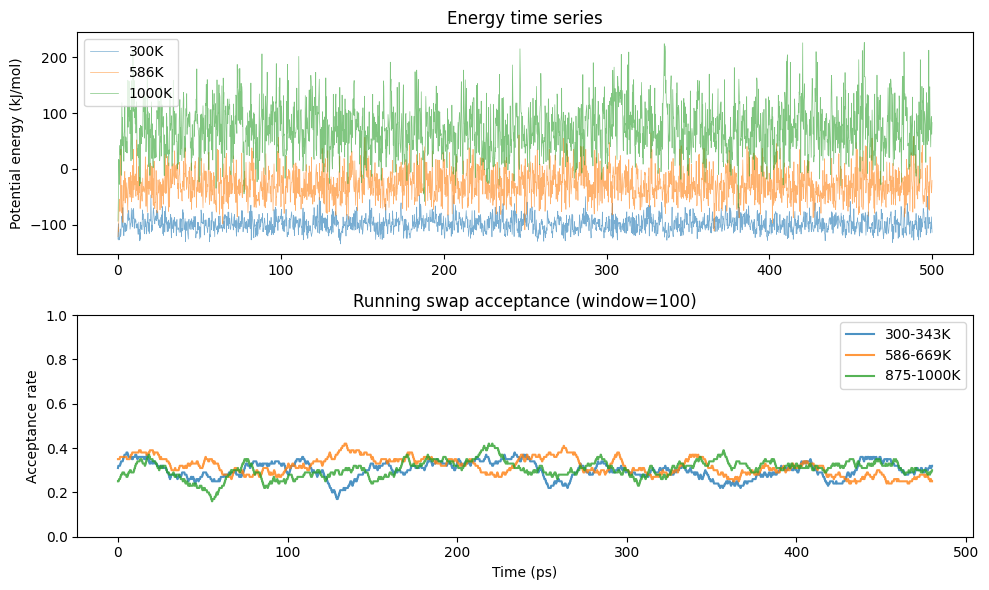

In [4]:
# Swap acceptance rates between adjacent pairs
accept_rates = np.array(all_accepts.mean(axis=0))
print("Swap acceptance rates (adjacent pairs):")
for i in range(n_replicas - 1):
    print(f"  {temperatures[i]:.0f}K <-> {temperatures[i+1]:.0f}K: {accept_rates[i]:.1%}")

warmup = n_rounds // 5

# Mean potential energy by replica (after warmup)
print(f"\nMean potential energy by replica (after warmup):")
for i in range(n_replicas):
    mean_e = float(all_energies[warmup:, i].mean())
    std_e = float(all_energies[warmup:, i].std())
    print(f"  T={temperatures[i]:7.1f}K: E = {mean_e:8.1f} +/- {std_e:6.1f} kJ/mol")

# Energy time series
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

round_times = np.arange(n_rounds) * swap_every * dt  # ps
for i in [0, n_replicas // 2, n_replicas - 1]:
    axes[0].plot(round_times, all_energies[:, i], alpha=0.6, linewidth=0.5,
                 label=f"{temperatures[i]:.0f}K")
axes[0].set_ylabel("Potential energy (kJ/mol)")
axes[0].set_title("Energy time series")
axes[0].legend()

# Running swap acceptance rates
window = 100
for i in [0, n_replicas // 2, n_replicas - 2]:
    running_avg = np.convolve(np.array(all_accepts[:, i], dtype=float),
                              np.ones(window) / window, mode="valid")
    axes[1].plot(round_times[:len(running_avg)], running_avg, alpha=0.8,
                 label=f"{temperatures[i]:.0f}-{temperatures[i+1]:.0f}K")
axes[1].set_xlabel("Time (ps)")
axes[1].set_ylabel("Acceptance rate")
axes[1].set_title(f"Running swap acceptance (window={window})")
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 5. Ramachandran plot (parallel tempering, 300K)

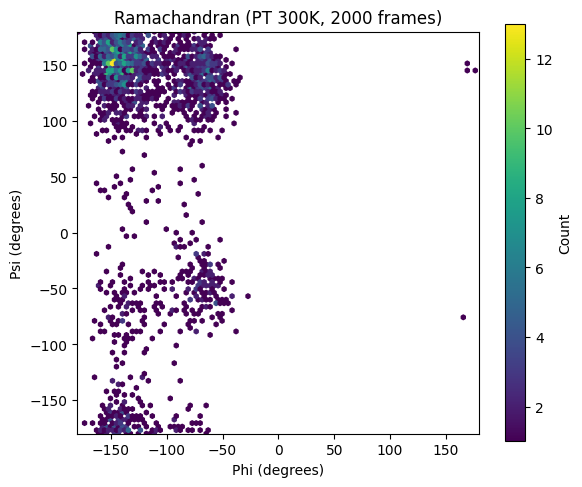

Phi range: [-179, 178] degrees
Psi range: [-180, 180] degrees


In [6]:
# Compute phi/psi from 300K trajectory (after warmup)
phi_idx = jnp.array(jaxmm.phi_indices(aldp.topology))
psi_idx = jnp.array(jaxmm.psi_indices(aldp.topology))

traj_equil_pt = traj_target[warmup:]
phi_pt = np.degrees(np.array(jaxmm.dihedral_angle(traj_equil_pt, phi_idx)[:, 0]))
psi_pt = np.degrees(np.array(jaxmm.dihedral_angle(traj_equil_pt, psi_idx)[:, 0]))

fig, ax = plt.subplots(figsize=(6, 5))
ax.hexbin(phi_pt, psi_pt, gridsize=100, cmap="viridis", mincnt=1)
ax.set_xlabel("Phi (degrees)")
ax.set_ylabel("Psi (degrees)")
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_title(f"Ramachandran (PT 300K, {traj_equil_pt.shape[0]} frames)")
ax.set_aspect("equal")
plt.colorbar(ax.collections[0], ax=ax, label="Count")
plt.tight_layout()
plt.show()

print(f"Phi range: [{phi_pt.min():.0f}, {phi_pt.max():.0f}] degrees")
print(f"Psi range: [{psi_pt.min():.0f}, {psi_pt.max():.0f}] degrees")

## 6. Comparison with single-temperature Langevin

Run plain Langevin at 300K for the same total simulation time, then compare
Ramachandran plots side by side. PT should show multiple basins (C7eq, C7ax,
alpha-R); single-T may show only 1-2. The implicit solvent landscape
has different basin depths compared to vacuum.

Running single-T Langevin: 500000 steps at 300K...
Done in 13.6s


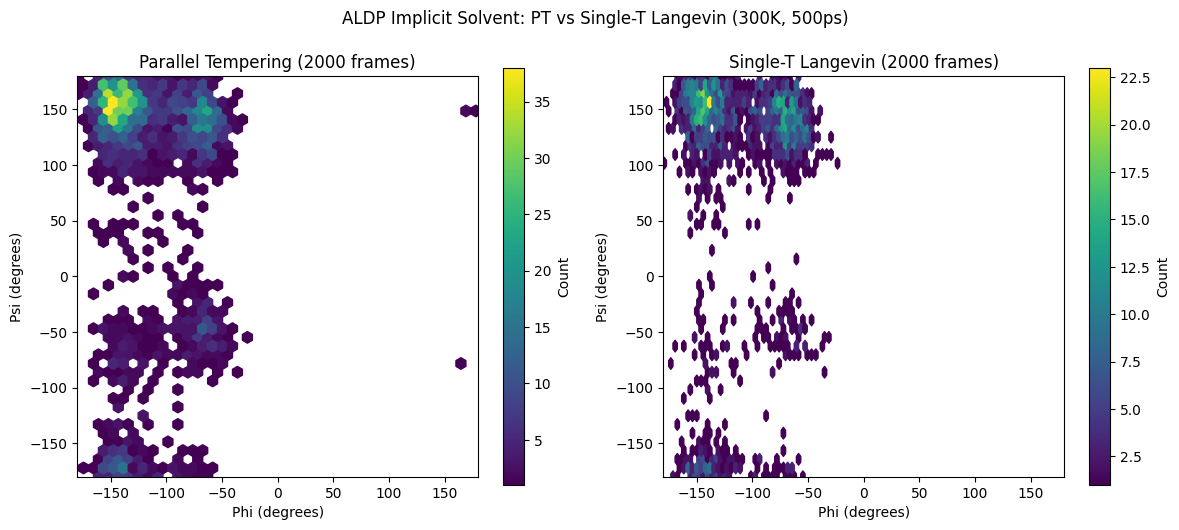

PT: 206 grid cells above 2% of max count
Single-T: 179 grid cells above 2% of max count


In [7]:
# Single-T Langevin: same total steps as PT (500k steps)
n_steps_single = n_rounds * swap_every  # 500k
save_every_single = swap_every          # save at same frequency as PT rounds

print(f"Running single-T Langevin: {n_steps_single} steps at 300K...")
t0 = time.perf_counter()
result_single = jax.jit(
    jaxmm.langevin_baoab, static_argnames=("n_steps", "save_every")
)(
    pos_jnp, jnp.zeros_like(pos_jnp), params,
    dt, 300.0, friction,
    n_steps_single, save_every=save_every_single, key=random.key(123),
)
traj_single = result_single.trajectory_positions
traj_single.block_until_ready()
t_single = time.perf_counter() - t0
print(f"Done in {t_single:.1f}s")

# Compute phi/psi for single-T (after warmup)
traj_equil_single = traj_single[warmup:]
phi_single = np.degrees(np.array(jaxmm.dihedral_angle(traj_equil_single, phi_idx)[:, 0]))
psi_single = np.degrees(np.array(jaxmm.dihedral_angle(traj_equil_single, psi_idx)[:, 0]))

# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hexbin(phi_pt, psi_pt, gridsize=40, cmap="viridis", mincnt=1)
ax1.set_xlabel("Phi (degrees)")
ax1.set_ylabel("Psi (degrees)")
ax1.set_xlim(-180, 180)
ax1.set_ylim(-180, 180)
ax1.set_title(f"Parallel Tempering ({traj_equil_pt.shape[0]} frames)")
ax1.set_aspect("equal")
plt.colorbar(ax1.collections[0], ax=ax1, label="Count")

ax2.hexbin(phi_single, psi_single, gridsize=40, cmap="viridis", mincnt=1)
ax2.set_xlabel("Phi (degrees)")
ax2.set_ylabel("Psi (degrees)")
ax2.set_xlim(-180, 180)
ax2.set_ylim(-180, 180)
ax2.set_title(f"Single-T Langevin ({traj_equil_single.shape[0]} frames)")
ax2.set_aspect("equal")
plt.colorbar(ax2.collections[0], ax=ax2, label="Count")

plt.suptitle("ALDP Implicit Solvent: PT vs Single-T Langevin (300K, 500ps)", y=1.02)
plt.tight_layout()
plt.show()

# Count distinct basins visited (rough heuristic: unique hexbin cells with >2% of max count)
for name, phi, psi in [("PT", phi_pt, psi_pt), ("Single-T", phi_single, psi_single)]:
    bins = np.arange(-180, 181, 10)
    hist, _, _ = np.histogram2d(phi, psi, bins=[bins, bins])
    threshold = hist.max() * 0.02
    n_occupied = (hist > threshold).sum()
    print(f"{name}: {n_occupied} grid cells above 2% of max count")